# Challenge Set 1: MTA Turnstile Data

Problem statement:
WTWY needs to optimize their street teams so that they can get the most email signups for their annual OMGYN Gala. Ideally, the email signups will convert at a high rate to gala attendees, and among attendees, many will make contributions to WTWY.



Objective: Task to find supplemental data to incorporate into MTA trunstile data. 

Methodology: Use the geographic coordinates of the subway station map it to the US Census using the US Census Geocoder, to match the corresponding census tract GEOID.  Using the NYC Census finder to download demographic, social, economic and housing info for all New York Counties

In [2]:
import pandas as pd
from datetime import datetime, timedelta
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

# Objective: Come up with additional resources that can help differentiate our analysis

Since we have an extra member, took it as an opportunity to think outside the box.  Challenge myself to find and dissect datasets on my own.  After some consideration I decided on incorporating  demographic data using census data . 

NYC has a nifty census website called NYC population FactFinder.
https://popfactfinder.planning.nyc.gov/#12.13/40.71875/-73.98622

" New York City Population FactFinder (NYC PFF) provides detailed population and housing profiles for user defined areas within New York City. Using data from decennial censuses and the American Community Survey, the profiles are comprehensive, covering the most basic population statistics, along with detailed social, economic, and housing information"

<img src="populationfinder.png">

Due to time constraint and most of our top stations being in Manhattan, I only pulled the counties situated in
Manhatttan and the most recent 5yr average ACS (American Community Survey) economic data. 

Dataset is quite extensive, I pulled what I needed for our project.  Ideally one will work with the client to idenfity the demographic profile they like to target

In [21]:
#Import CSV files, pulled all the census tracts in NYC counties and its associated ACS economic data
def get_census_data(file_url):
    data = pd.read_csv(file_url, skiprows = 0)
    return data

census_data = get_census_data('ACS_17_5YR_S2301_with_ann.csv')
census_data.rename(index=str, columns={"GEO.id2": "GEOID"},inplace=True)

In [22]:
#Check to see how many counties I pulled, there are 288 unique census tracts in Manhattan
census_data.describe()

,GEO.id,GEOID,GEO.display-label,HC01_EST_VC01,HC01_MOE_VC01,HC02_EST_VC01,HC02_MOE_VC01,HC03_EST_VC01,HC03_MOE_VC01,HC04_EST_VC01,...,HC04_EST_VC46,HC04_MOE_VC46,HC01_EST_VC47,HC01_MOE_VC47,HC02_EST_VC47,HC02_MOE_VC47,HC03_EST_VC47,HC03_MOE_VC47,HC04_EST_VC47,HC04_MOE_VC47
count,289,289,289,289,289,289,289,289,289,289,...,289,289,289,289,289,289,289,289,289,289
unique,289,289,289,279,238,206,68,208,66,124,...,132,178,276,227,156,106,161,102,91,91
top,1400000US36061015700,36061015100,"Census Tract 127, New York County, New York",0,11,-,5.2,-,5.8,4.3,...,0,**,0,11,-,4.5,-,4.9,0,1.9
freq,1,1,1,5,5,5,17,5,16,8,...,92,11,7,7,7,10,7,10,21,15


In [76]:
#Looks like we got some header issuse, the 2nd line contains the headers but they are rather long
#for now I will remove them into a separate list and reference them later
census_data.head(5)

,GEO.id,GEOID,GEO.display-label,HC01_EST_VC01,HC01_MOE_VC01,HC02_EST_VC01,HC02_MOE_VC01,HC03_EST_VC01,HC03_MOE_VC01,HC04_EST_VC01,...,HC04_EST_VC46,HC04_MOE_VC46,HC01_EST_VC47,HC01_MOE_VC47,HC02_EST_VC47,HC02_MOE_VC47,HC03_EST_VC47,HC03_MOE_VC47,HC04_EST_VC47,HC04_MOE_VC47
0,Id,Id2,Geography,Total; Estimate; Population 16 years and over,Total; Margin of Error; Population 16 years an...,Labor Force Participation Rate; Estimate; Popu...,Labor Force Participation Rate; Margin of Erro...,Employment/Population Ratio; Estimate; Populat...,Employment/Population Ratio; Margin of Error; ...,Unemployment rate; Estimate; Population 16 yea...,...,Unemployment rate; Estimate; EDUCATIONAL ATTAI...,Unemployment rate; Margin of Error; EDUCATIONA...,Total; Estimate; EDUCATIONAL ATTAINMENT - Popu...,Total; Margin of Error; EDUCATIONAL ATTAINMENT...,Labor Force Participation Rate; Estimate; EDUC...,Labor Force Participation Rate; Margin of Erro...,Employment/Population Ratio; Estimate; EDUCATI...,Employment/Population Ratio; Margin of Error; ...,Unemployment rate; Estimate; EDUCATIONAL ATTAI...,Unemployment rate; Margin of Error; EDUCATIONA...
1,1400000US36061000100,36061000100,"Census Tract 1, New York County, New York",0,11,-,**,-,**,-,...,-,**,0,11,-,**,-,**,-,**
2,1400000US36061000201,36061000201,"Census Tract 2.01, New York County, New York",2187,318,46.4,7.8,45.1,8,2.7,...,0.8,2.8,160,68,81.3,16.3,77.5,17.4,4.6,7.7
3,1400000US36061000202,36061000202,"Census Tract 2.02, New York County, New York",6524,523,49.5,5.4,41.2,5.6,16.8,...,22.3,18.1,1325,279,86.4,6.9,84,8.2,2.8,3.1
4,1400000US36061000500,36061000500,"Census Tract 5, New York County, New York",0,11,-,**,-,**,-,...,-,**,0,11,-,**,-,**,-,**


In [83]:
#Save down the header with descriptions into census_header_list
#Remove the first row with the descriptions
census_header_list = [census_data.columns, census_data.iloc[0]]
census_data.drop(census_data.index[0],axis=0, inplace=True)
census_data.head()

,GEO.id,GEOID,GEO.display-label,HC01_EST_VC01,HC01_MOE_VC01,HC02_EST_VC01,HC02_MOE_VC01,HC03_EST_VC01,HC03_MOE_VC01,HC04_EST_VC01,...,HC04_EST_VC46,HC04_MOE_VC46,HC01_EST_VC47,HC01_MOE_VC47,HC02_EST_VC47,HC02_MOE_VC47,HC03_EST_VC47,HC03_MOE_VC47,HC04_EST_VC47,HC04_MOE_VC47
1,1400000US36061000100,36061000100,"Census Tract 1, New York County, New York",0,11,-,**,-,**,-,...,-,**,0,11,-,**,-,**,-,**
2,1400000US36061000201,36061000201,"Census Tract 2.01, New York County, New York",2187,318,46.4,7.8,45.1,8,2.7,...,0.8,2.8,160,68,81.3,16.3,77.5,17.4,4.6,7.7
3,1400000US36061000202,36061000202,"Census Tract 2.02, New York County, New York",6524,523,49.5,5.4,41.2,5.6,16.8,...,22.3,18.1,1325,279,86.4,6.9,84,8.2,2.8,3.1
4,1400000US36061000500,36061000500,"Census Tract 5, New York County, New York",0,11,-,**,-,**,-,...,-,**,0,11,-,**,-,**,-,**
5,1400000US36061000600,36061000600,"Census Tract 6, New York County, New York",9607,1014,42,5.9,36.7,5.8,12.5,...,0,5.3,1302,471,81.9,12.2,66.9,14.8,18.3,17.6


NYC has a great open data portal, NYC OpenData
https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49

<img src="NYCSubway_Station.png">

In [86]:
#Download csv from the MTA a list of subway stations with corresponding geo coordinates
def get_subway_station(file_url):
    data = pd.read_csv(file_url)
    return data

subway_station = get_subway_station('subway_station.csv')

In [87]:
subway_station.head()

,URL,OBJECTID,NAME,the_geom,LINE,NOTES
0,http://web.mta.info/nyct/service/,1,Astor Pl,POINT (-73.99106999861966 40.73005400028978),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."
1,http://web.mta.info/nyct/service/,2,Canal St,POINT (-74.00019299927328 40.71880300107709),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."
2,http://web.mta.info/nyct/service/,3,50th St,POINT (-73.98384899986625 40.76172799961419),1-2,"1-all times, 2-nights"
3,http://web.mta.info/nyct/service/,4,Bergen St,POINT (-73.97499915116808 40.68086213682956),2-3-4,"4-nights, 3-all other times, 2-all times"
4,http://web.mta.info/nyct/service/,5,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568),3-4,"4-nights, 3-all other times"


In [88]:
#Note the_geom columns with the geo coordinates need to do a bit of data cleaning
#to break out the coordinates and convert it to a string list
subway_station['the_geom'] = subway_station['the_geom'].str.replace("POINT","")
subway_station['the_geom'] = subway_station['the_geom'].str.replace("(","")
subway_station['the_geom'] = subway_station['the_geom'].str.replace(")","")
subway_station['the_geom'] = subway_station['the_geom'].str.lstrip()
subway_station['the_geom'] = subway_station['the_geom'].str.split(" ")
subway_station.head(5)

,URL,OBJECTID,NAME,the_geom,LINE,NOTES
0,http://web.mta.info/nyct/service/,1,Astor Pl,"[-73.99106999861966, 40.73005400028978]",4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."
1,http://web.mta.info/nyct/service/,2,Canal St,"[-74.00019299927328, 40.71880300107709]",4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."
2,http://web.mta.info/nyct/service/,3,50th St,"[-73.98384899986625, 40.76172799961419]",1-2,"1-all times, 2-nights"
3,http://web.mta.info/nyct/service/,4,Bergen St,"[-73.97499915116808, 40.68086213682956]",2-3-4,"4-nights, 3-all other times, 2-all times"
4,http://web.mta.info/nyct/service/,5,Pennsylvania Ave,"[-73.89488591154061, 40.66471445143568]",3-4,"4-nights, 3-all other times"


In [89]:
#Create two new new columns for Longitude and Latitude
subway_station.loc[:,'LAT'] = subway_station['the_geom'].map(lambda x: x[0])
subway_station.loc[:,'LONG'] = subway_station['the_geom'].map(lambda x: x[1])
subway_station.head(5)

,URL,OBJECTID,NAME,the_geom,LINE,NOTES,LAT,LONG
0,http://web.mta.info/nyct/service/,1,Astor Pl,"[-73.99106999861966, 40.73005400028978]",4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",-73.99106999861966,40.73005400028978
1,http://web.mta.info/nyct/service/,2,Canal St,"[-74.00019299927328, 40.71880300107709]",4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",-74.00019299927328,40.71880300107709
2,http://web.mta.info/nyct/service/,3,50th St,"[-73.98384899986625, 40.76172799961419]",1-2,"1-all times, 2-nights",-73.98384899986625,40.76172799961419
3,http://web.mta.info/nyct/service/,4,Bergen St,"[-73.97499915116808, 40.68086213682956]",2-3-4,"4-nights, 3-all other times, 2-all times",-73.97499915116808,40.68086213682956
4,http://web.mta.info/nyct/service/,5,Pennsylvania Ave,"[-73.89488591154061, 40.66471445143568]",3-4,"4-nights, 3-all other times",-73.89488591154061,40.66471445143568


#### Census GeoCoder
https://pypi.org/project/censusgeocode/

Census Geocode is a light weight Python wrapper for the US Census Geocoder API, compatible with both Python 2 and 3. It comes packaged with a simple command line tool for geocoding an address to a longitude and latitude, or a batch file into a parsed address and coordinates.

It's strongly recommended to review the Census Geocoder docs before using this module.

In [90]:
#Define a function that uses the Census GeoCoder and return the census tract geocode 
#!pip install censusgeocode
import censusgeocode as cg

def get_geoid_coord(lat,long):
    """ A light weight Python wrapper for the US Census Geocoder API
        tool for geocoding an address to a longitude and latitude, 
        or a batch file into a parsed address and coordinates. 
        
        input: latitude and longitude
        output: corresponding census tracts
        """
    results = cg.coordinates(x=lat, y=long)
    
#Get the corresponding census tract code GEOID given the coordinates
    return results['Census Tracts'][0]["GEOID"]

In [92]:
#Test a location to makes sure it returns the correct GEOID
censustract =  get_geoid_coord(-74.00858473570133, 40.714111000774025)
censustract

'36061002100'

In [426]:
#Create a new column in subway_station dataframe and apply the function for each row, passing the LAT and LON
#Note this takes a hot minute or more and can time out at times
subway_station['GEOID'] = subway_station[['LAT','LONG']].apply(lambda x:get_geoid_coord(x.LAT,x.LONG), axis=1)

In [427]:
#Pull up one location and check that it pulled the up correct geocode
subway_station.iloc[120]

URL                http://web.mta.info/nyct/service/
OBJECTID                                         121
NAME                  Atlantic Av - Barclay's Center
the_geom    [-73.97678343963167, 40.684488323453685]
LINE                                             B-Q
NOTES           B-weekdays and evenings, Q-all times
LAT                               -73.97678343963167
LONG                              40.684488323453685
GEOID                                    36047003500
Name: 120, dtype: object

In [429]:
#Saving subway_station dataframe with the geocode data into a pickle and reopening it 
with open('subway_station.pickle', 'wb') as to_write:
    pickle.dump(subway_station, to_write)

In [93]:
with open('subway_station.pickle','rb') as read_file:
    subway_station = pickle.load(read_file)

In [125]:
#Merge the subway_station dataframe with our census data on GEOID to create a combined dataframe
subway_census = pd.merge(subway_station, census_data, how='inner', on='GEOID')

In [126]:
subway_census.head(5)

,URL,OBJECTID,NAME,the_geom,LINE,NOTES,LAT,LONG,GEOID,GEO.id,...,HC04_EST_VC46,HC04_MOE_VC46,HC01_EST_VC47,HC01_MOE_VC47,HC02_EST_VC47,HC02_MOE_VC47,HC03_EST_VC47,HC03_MOE_VC47,HC04_EST_VC47,HC04_MOE_VC47
0,http://web.mta.info/nyct/service/,1,Astor Pl,"[-73.99106999861966, 40.73005400028978]",4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",-73.99106999861966,40.73005400028978,36061005700,1400000US36061005700,...,0,46.8,1650,204,89.4,3.8,87.9,3.9,1.2,1.3
1,http://web.mta.info/nyct/service/,401,8th St - NYU,"[-73.99250799849149, 40.73046499853991]",N-Q-R-W,"N-all times, Q-nights, R-all times exc nights",-73.99250799849149,40.73046499853991,36061005700,1400000US36061005700,...,0,46.8,1650,204,89.4,3.8,87.9,3.9,1.2,1.3
2,http://web.mta.info/nyct/service/,2,Canal St,"[-74.00019299927328, 40.71880300107709]",4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",-74.00019299927328,40.71880300107709,36061004500,1400000US36061004500,...,16.2,21.8,485,101,84.5,6.1,81,6.4,4.1,3.6
3,http://web.mta.info/nyct/service/,417,Canal St,"[-74.0018260000577, 40.71946500105898]",R-W,"N-nights, R-all other times",-74.0018260000577,40.71946500105898,36061004500,1400000US36061004500,...,16.2,21.8,485,101,84.5,6.1,81,6.4,4.1,3.6
4,http://web.mta.info/nyct/service/,435,Canal St,"[-74.00105471306033, 40.718814263587134]",N-Q,"N-all times, Q-weekdays and evenings",-74.00105471306033,40.718814263587134,36061004500,1400000US36061004500,...,16.2,21.8,485,101,84.5,6.1,81,6.4,4.1,3.6


In [127]:
#Pickle the new combined dataframe
with open('subway_census.pickle', 'wb') as to_write:
    pickle.dump(subway_census, to_write)

In [128]:
#Remember some of the columns have cryptic column names
subway_census.columns

Index(['URL', 'OBJECTID', 'NAME', 'the_geom', 'LINE', 'NOTES', 'LAT', 'LONG',
       'GEOID', 'GEO.id',
       ...
       'HC04_EST_VC46', 'HC04_MOE_VC46', 'HC01_EST_VC47', 'HC01_MOE_VC47',
       'HC02_EST_VC47', 'HC02_MOE_VC47', 'HC03_EST_VC47', 'HC03_MOE_VC47',
       'HC04_EST_VC47', 'HC04_MOE_VC47'],
      dtype='object', length=291)

#### Identify the columns to pull from the census ACS
-------
* HC01_EST_VC29 - Total; Estimate; Population 20 to 64 years - SEX - Female
* HC02_EST_VC01 - Labor Force Participation Rate; Estimate; Population 16 years and over
* HC02_EST_VC29 - Labor Force Participation Rate; Estimate; Population 20 to 64 years - SEX - Female
* HC04_EST_VC29 - Unemployment rate; Estimate; Population 20 to 64 years - SEX - Female
* HC02_EST_VC47 - Total; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Bachelor's degree or higher

In [289]:
#create a new dataframe from with the columns that we want
subway_demog = subway_census[['NAME',
                              'HC01_EST_VC29',
                              'HC02_EST_VC01',
                              'HC02_EST_VC29',
                              'HC04_EST_VC29',
                              'HC02_EST_VC47' ]]

In [290]:
#change the column names to something a bit more descriptive
subway_demog.columns = ['Subway Station',
                        'Total Female Population',
                        'Labor Force Participation',
                        'Female Labor Force Participation',
                        'Female Unemployment Rate',
                        'Bachelor degree or higher']

In [291]:
#Check to see if subway station is unique, seems like there are some duplicates
subway_demog['Subway Station'].value_counts().sort_index()

103rd St                             3
110th St                             1
116th St                             3
116th St - Columbia University       1
125th St                             4
135th St                             2
137th St - City College              1
145th St                             3
14th St                              3
155th St                             2
157th St                             1
163rd St - Amsterdam Av              1
168th St                             2
175th St                             1
181st St                             2
18th St                              1
190th St                             1
191st St                             1
1st Ave                              1
207th St                             1
215th St                             1
23rd St                              5
28th St                              3
33rd St                              1
34th St - Hudson Yards               1
34th St - Penn Station   

In [292]:
#Investigate a duplicate, it looks like its safe to remove the duplicates
subway_census[subway_census['NAME'] == 'Wall St']

,URL,OBJECTID,NAME,the_geom,LINE,NOTES,LAT,LONG,GEOID,GEO.id,...,HC04_EST_VC46,HC04_MOE_VC46,HC01_EST_VC47,HC01_MOE_VC47,HC02_EST_VC47,HC02_MOE_VC47,HC03_EST_VC47,HC03_MOE_VC47,HC04_EST_VC47,HC04_MOE_VC47
134,http://web.mta.info/nyct/service/,420,Wall St,"[-74.01186199860112, 40.70755700086603]",4-5,"4-all times, 5-weekdays",-74.01186199860112,40.70755700086603,36061000700,1400000US36061000700,...,0,12.9,5320,779,93.3,3.4,90.1,3.8,3.5,2.8
136,http://web.mta.info/nyct/service/,430,Wall St,"[-74.00909999844257, 40.706820999753376]",2-3,"2-all times, 3-all times exc nights",-74.00909999844257,40.706820999753376,36061000700,1400000US36061000700,...,0,12.9,5320,779,93.3,3.4,90.1,3.8,3.5,2.8


In [293]:
#Remove the duplicates and keep the last
subway_demog = subway_demog.drop_duplicates(subset='Subway Station', keep="last")

In [294]:
#Need to remove the - from the Female Unemployment columns so I can convert it to numeric
subway_demog['Female Unemployment Rate'] = subway_demog['Female Unemployment Rate'].str.replace("-","0")
subway_demog['Bachelor degree or higher'] = subway_demog['Bachelor degree or higher'].str.replace("-","0")

In [295]:
#To get statistics we need to convert the columns to numeric
subway_demog['Total Female Population'] = pd.to_numeric(
                                                        subway_demog['Total Female Population'])

subway_demog['Female Labor Force Participation'] = pd.to_numeric(
                                                        subway_demog['Female Labor Force Participation'])
subway_demog['Labor Force Participation'] = pd.to_numeric(
                                                        subway_demog['Labor Force Participation'])
subway_demog['Female Unemployment Rate'] = pd.to_numeric(
                                                        subway_demog['Female Unemployment Rate'])
subway_demog['Bachelor degree or higher'] = pd.to_numeric(
                                                        subway_demog['Bachelor degree or higher'])

In [296]:
subway_demog.head(5)

,Subway Station,Total Female Population,Labor Force Participation,Female Labor Force Participation,Female Unemployment Rate,Bachelor degree or higher
0,Astor Pl,970,69.9,83.4,0.9,89.4
1,8th St - NYU,970,69.9,83.4,0.9,89.4
7,7th Ave,924,76.5,78.0,4.0,91.8
10,Delancey St - Essex St,2277,64.9,77.4,7.6,92.7
11,Grand St,2277,64.9,77.4,7.6,92.7


In [257]:
#Import our top 10 stations via a list, there were some slight discrepancies in the naming conventions
top_10 = ['34th St - Penn Station', 
          'Grand Central - 42nd St', 
          'Fulton St',
          '23rd St',
          'Wall St',
          '5th Ave - 53rd St',
        '47th-50th Sts - Rockefeller Ctr',
        'Lexington Ave - 53rd St',
          'Chambers St',
          '34th St - Hudson Yards']

In [298]:
#Filter the dataframe for only our top 10 stations
top10_df = subway_demog[subway_demog['Subway Station'].isin(top_10)]

In [300]:
#What are the corresponding demographics for our top 10 stations
top10_df

,Subway Station,Total Female Population,Labor Force Participation,Female Labor Force Participation,Female Unemployment Rate,Bachelor degree or higher
50,5th Ave - 53rd St,38,83.3,76.3,0.0,86.5
51,Lexington Ave - 53rd St,2797,77.6,91.0,2.1,94.8
80,Grand Central - 42nd St,1707,74.7,85.1,2.3,94.4
94,47th-50th Sts - Rockefeller Ctr,48,88.7,70.8,0.0,100.0
106,34th St - Penn Station,82,85.1,72.0,3.4,92.1
109,23rd St,1251,76.3,78.0,8.3,89.0
120,Fulton St,2979,80.8,79.9,4.3,95.0
125,Chambers St,1465,42.7,68.4,4.5,89.4
136,Wall St,4203,88.6,90.9,4.6,93.3
148,34th St - Hudson Yards,2287,86.2,81.9,3.8,92.5


In [301]:
#Check make sure the columns are all numeric
top10_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 50 to 148
Data columns (total 6 columns):
Subway Station                      10 non-null object
Total Female Population             10 non-null int64
Labor Force Participation           10 non-null float64
Female Labor Force Participation    10 non-null float64
Female Unemployment Rate            10 non-null float64
Bachelor degree or higher           10 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 560.0+ bytes


In [302]:
#Sort top 10 station by female labor force participation and Bachelor degree or higher
top10_grp = top10_df.groupby(['Total Female Population','Female Labor Force Participation','Bachelor degree or higher'], as_index=False)
top10_df.sort_values(['Total Female Population', 
                       'Female Labor Force Participation',
                       'Bachelor degree or higher'], ascending=False, inplace=True)

/Users/robfang29/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [303]:
top10_df

,Subway Station,Total Female Population,Labor Force Participation,Female Labor Force Participation,Female Unemployment Rate,Bachelor degree or higher
136,Wall St,4203,88.6,90.9,4.6,93.3
120,Fulton St,2979,80.8,79.9,4.3,95.0
51,Lexington Ave - 53rd St,2797,77.6,91.0,2.1,94.8
148,34th St - Hudson Yards,2287,86.2,81.9,3.8,92.5
80,Grand Central - 42nd St,1707,74.7,85.1,2.3,94.4
125,Chambers St,1465,42.7,68.4,4.5,89.4
109,23rd St,1251,76.3,78.0,8.3,89.0
106,34th St - Penn Station,82,85.1,72.0,3.4,92.1
94,47th-50th Sts - Rockefeller Ctr,48,88.7,70.8,0.0,100.0
50,5th Ave - 53rd St,38,83.3,76.3,0.0,86.5


In [304]:
#Get statistics on our top 10 subway station
top10_df.describe()

,Total Female Population,Labor Force Participation,Female Labor Force Participation,Female Unemployment Rate,Bachelor degree or higher
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1685.700000,78.400000,79.430000,3.330000,92.700000
std,1406.845569,13.494279,7.937821,2.440423,3.795612
min,38.000000,42.700000,68.400000,0.000000,86.500000
25%,374.250000,76.625000,73.075000,2.150000,90.075000
50%,1586.000000,82.050000,78.950000,3.600000,92.900000
75%,2669.500000,85.925000,84.300000,4.450000,94.700000
max,4203.000000,88.700000,91.000000,8.300000,100.000000


In [306]:
#Let compare it with the statistics for the all of manhattan
subway_demog.describe()

,Total Female Population,Labor Force Participation,Female Labor Force Participation,Female Unemployment Rate,Bachelor degree or higher
count,94.000000,94.000000,94.000000,94.000000,94.000000
mean,1807.287234,68.147872,74.175532,5.554255,86.662766
std,1055.794351,15.929676,14.456607,4.050585,14.540784
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,986.500000,64.450000,71.025000,2.825000,86.250000
50%,1750.000000,70.000000,77.550000,4.450000,89.650000
75%,2492.750000,76.950000,81.225000,7.600000,92.475000
max,4752.000000,90.800000,100.000000,21.200000,100.000000


###### On average these areas have higher labor force participation, female labor force participation and higher education

In [333]:
#What are the top 10 subway station by Female Population, Labor Force Participatiob and Education attainment
mask = ((subway_demog['Total Female Population'] > 2490) & 
        (subway_demog['Female Labor Force Participation'] > 77.5)) 
subway_demog = subway_demog[mask]
subway_demog.sort_values(['Bachelor degree or higher',
                          'Total Female Population', 
                          'Female Labor Force Participation'], ascending=False, inplace=True)

In [334]:
subway_demog.head(10)

,Subway Station,Total Female Population,Labor Force Participation,Female Labor Force Participation,Female Unemployment Rate,Bachelor degree or higher
120,Fulton St,2979,80.8,79.9,4.3,95.0
51,Lexington Ave - 53rd St,2797,77.6,91.0,2.1,94.8
91,145th St,2563,73.8,81.7,4.3,94.1
135,Broad St,4203,88.6,90.9,4.6,93.3
136,Wall St,4203,88.6,90.9,4.6,93.3
77,18th St,2971,78.2,90.6,3.6,92.3
126,Canal St,2969,66.7,84.8,2.9,90.0
149,72nd St,4752,74.5,81.3,2.9,89.6
84,Harlem - 148 St,2528,63.2,78.1,15.1,86.5
113,181st St,2698,73.7,77.7,2.8,86.2


In [335]:
top10_dm = subway_demog[0:9]

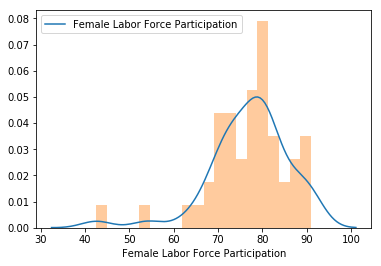

In [326]:
#Let see what the distribution looks like for Female Labor Force Participation
import seaborn as sns
sns.kdeplot(subway_demog['Female Labor Force Participation'])
sns.distplot(subway_demog['Female Labor Force Participation'], kde=False,bins=20,norm_hist=True);

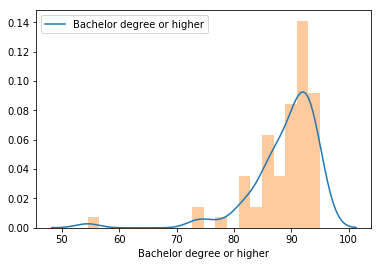

In [313]:
#Let see what the distribution looks like for Bachelor Degree or higher
import seaborn as sns
sns.kdeplot(subway_demog['Bachelor degree or higher'])
sns.distplot(subway_demog['Bachelor degree or higher'], kde=False,bins=20,norm_hist=True);

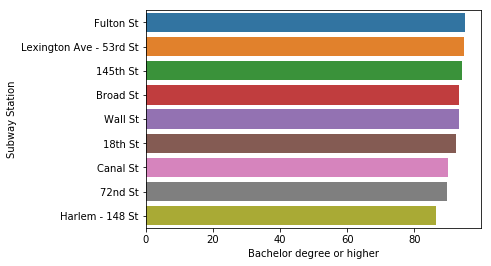

In [337]:
#Create a bar chart of our top 10 subway station by our chosen demographics
sns.barplot(y = 'Subway Station',x='Bachelor degree or higher',data=top10_dm);